# Pneumonia Pre-Processing and Modeling

## Import Revelant Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

## Import Data

In [2]:
df_train = pd.read_pickle('Clean_Data/training_data.csv')
df_test = pd.read_pickle('Clean_Data/testing_data.csv')
df_val = pd.read_pickle('Clean_Data/validation_data.csv')

## Explore Data

In [3]:
print(df_train.head(1))
print(df_test.head(1))
print(df_val.head(1))

                                               Image   Label
0  [[29, 27, 30, 28, 27, 26, 28, 29, 30, 29, 28, ...  Normal
                                               Image   Label
0  [[25, 24, 21, 19, 19, 21, 20, 21, 20, 20, 20, ...  Normal
                                               Image   Label
0  [[6, 23, 32, 30, 40, 37, 44, 43, 40, 38, 39, 4...  Normal


In [4]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(5216, 2)
(624, 2)
(16, 2)


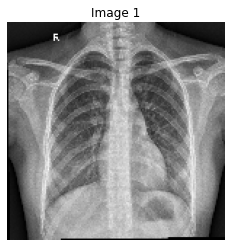

In [5]:
_ = plt.imshow(df_train['Image'][0], cmap='gray')
_ = plt.axis('off')
_ = plt.title('Image 1')

In [6]:
df_train['Image'][0].shape

(150, 150)

## Split Data & Reshape

In [7]:
X_train = df_train['Image']
# Reshape image array so 4D (Number of Images, Image Width, Image Height, Color Channels)
X_train = np.concatenate(X_train).reshape(X_train.shape[0], X_train[0].shape[0], X_train[0].shape[1])
X_train = np.expand_dims(X_train, axis=-1) # Add forth dimension for color channel
# Replace string labels with numeric (Pneumonia = 1, Normal = 0)
y_train = df_train['Label'].replace(['Pneumonia', 'Normal'],[1,0])

X_test = df_test['Image']
# Reshape image array so 4D (Number of Images, Image Width, Image Height, Color Channels)
X_test = np.concatenate(X_test).reshape(X_test.shape[0], X_test[0].shape[0], X_test[0].shape[1])
X_test = np.expand_dims(X_test, axis=-1) # Add forth dimension for color channel
# Replace string labels with numeric (Pneumonia = 1, Normal = 0)
y_test = df_test['Label'].replace(['Pneumonia', 'Normal'],[1,0])

X_val = df_val['Image']
# Reshape image array so 4D (Number of Images, Image Width, Image Height, Color Channels)
X_val = np.concatenate(X_val).reshape(X_val.shape[0], X_val[0].shape[0], X_val[0].shape[1])
X_val = np.expand_dims(X_val, axis=-1) # Add forth dimension for color channel
# Replace string labels with numeric (Pneumonia = 1, Normal = 0)
y_val = df_val['Label'].replace(['Pneumonia', 'Normal'],[1,0])

In [8]:
print('Training data shape : ', X_train.shape, y_train.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)
print('Validation data shape : ', X_val.shape, y_val.shape)

Training data shape :  (5216, 150, 150, 1) (5216,)
Testing data shape :  (624, 150, 150, 1) (624,)
Validation data shape :  (16, 150, 150, 1) (16,)


## Preprocess Data

### Data Augmentation

To avoid overfitting data due to small image set.
- Randomly flip horizontally
- Randomly rotate by 10%
- Randomly vary height by 10%
- Randomly vary width by 10%

In [9]:
# Augment images to randomly: flip horizontally, rotate 10%, vary height 10%, and vary width 10%
data_augmentation = keras.Sequential(
    [layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomHeight((-0.1,0.1)), 
     layers.experimental.preprocessing.RandomWidth((-0.1,0.1))
    ])

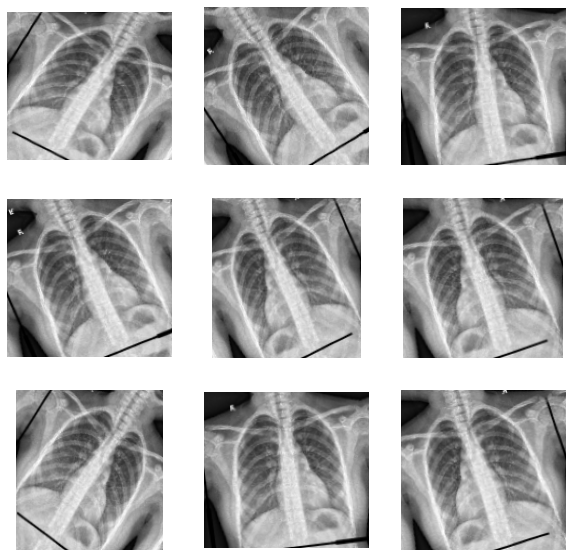

In [10]:
# Visualize 9 augmented samples on image 1
plt.figure(figsize=(10,10))
for i in range(9):
    augmented_images = data_augmentation(X_train)
    ax = plt.subplot(3,3, i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'), cmap='gray')
    plt.axis('off')

### Standardize

Training on GPU so will augment on device, synchronously with the rest of model execution.

Data augmentation inactive at test time, input samples will only be augmented buting fit.

In [11]:
inputs = keras.Input(shape=X_train.shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)

## Make Model

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

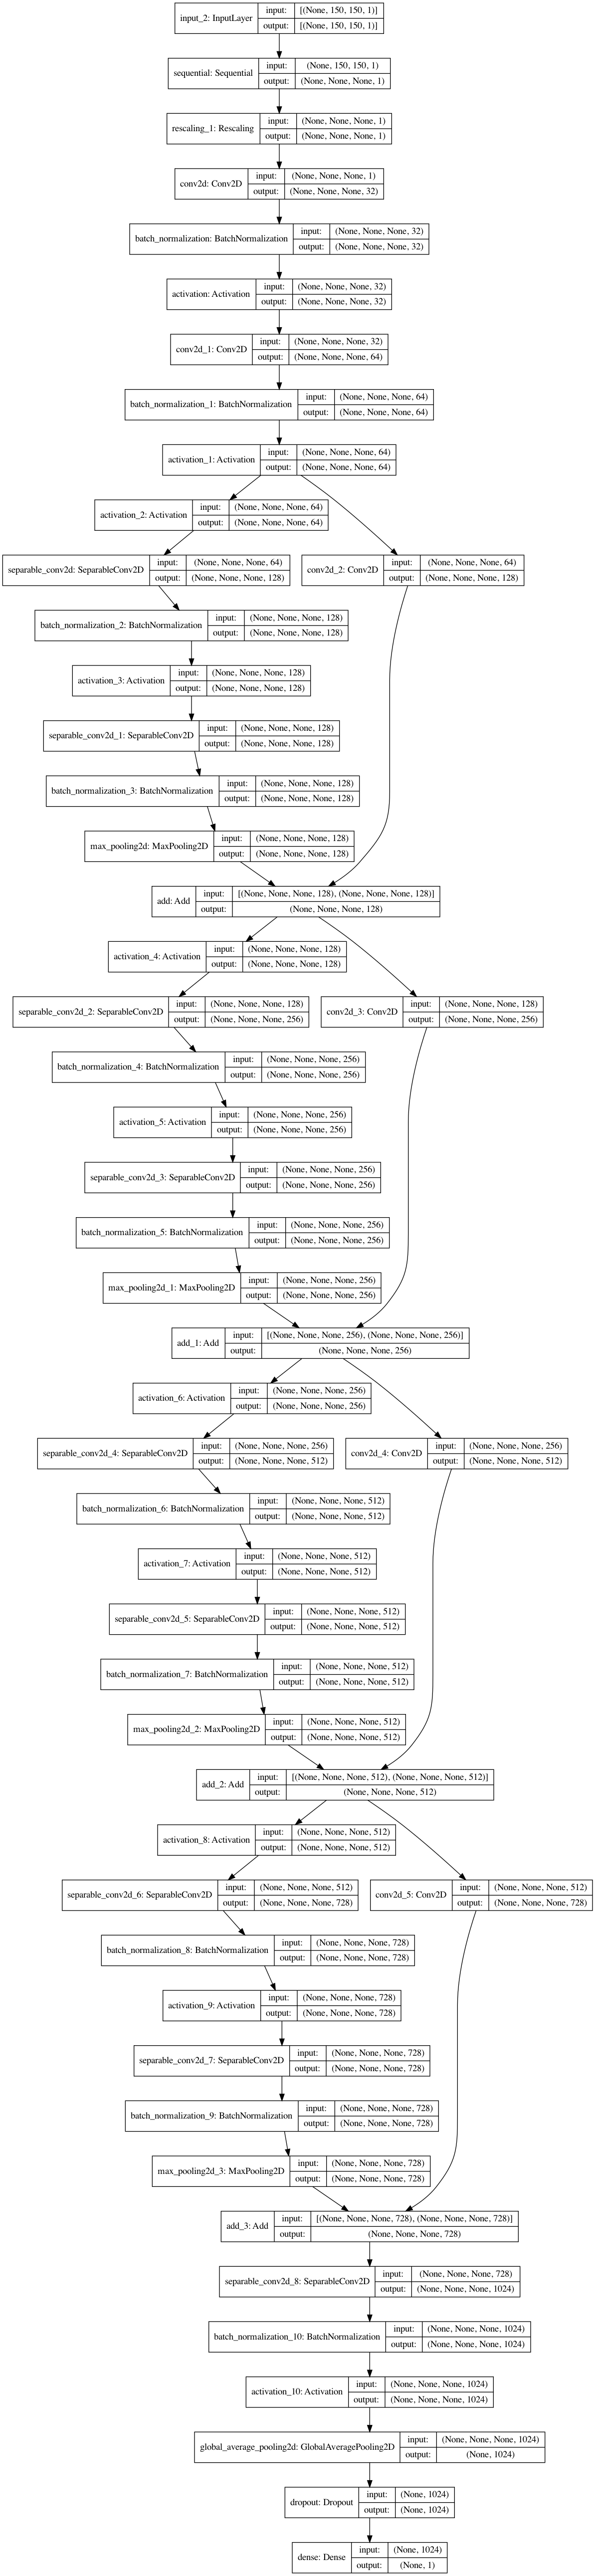

In [13]:
image_size = X_train.shape[1], X_train.shape[2]
model = make_model(input_shape=image_size + (1,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train Model

In [14]:
# Define recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Define precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#Define F1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc",f1_m,precision_m, recall_m])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 1 0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 1 0           sequential[1][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 320         rescaling_1[0][0]                
______________________________________________________________________________________________

In [16]:
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]
history = model.fit(x=X_train, y=y_train, epochs=5, callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/5
163/163 [==============================] - 421s 3s/step - loss: 0.3176 - acc: 0.8625 - f1_m: 0.9088 - precision_m: 0.9097 - recall_m: 0.9182 - val_loss: 2.8289 - val_acc: 0.5000 - val_f1_m: 0.6667 - val_precision_m: 0.5000 - val_recall_m: 1.0000
Epoch 2/5
163/163 [==============================] - 375s 2s/step - loss: 0.1674 - acc: 0.9340 - f1_m: 0.9547 - precision_m: 0.9546 - recall_m: 0.9585 - val_loss: 4.6155 - val_acc: 0.5000 - val_f1_m: 0.6667 - val_precision_m: 0.5000 - val_recall_m: 1.0000
Epoch 3/5
163/163 [==============================] - 380s 2s/step - loss: 0.1404 - acc: 0.9451 - f1_m: 0.9626 - precision_m: 0.9626 - recall_m: 0.9651 - val_loss: 5.2673 - val_acc: 0.5000 - val_f1_m: 0.6667 - val_precision_m: 0.5000 - val_recall_m: 1.0000
Epoch 4/5
163/163 [==============================] - 384s 2s/step - loss: 0.1262 - acc: 0.9514 - f1_m: 0.9669 - precision_m: 0.9679 - recall_m: 0.9683 - val_loss: 4.4658 - val_acc: 0.5000 - val_f1_m: 0.6667 - val_precision_m: 0.5000

## Evaluate Model Performance

In [17]:
# Evaluate model performance using test data
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test)

20/20 [==============================] - 14s 686ms/step - loss: 0.8881 - acc: 0.7452 - f1_m: 0.6383 - precision_m: 0.6379 - recall_m: 0.6406


In [18]:
# Print evaluation results
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

Loss: 0.888066828250885
Accuracy: 0.745192289352417
F1 Score: 0.6383241415023804
Precision: 0.6379310488700867
Recall: 0.640625
